In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model

import utils
import datetime
import os
np.random.seed(42)

#  XGBoost

Defining constants

In [5]:
person = 'UNIVERSITY AMERICAN'

cat_vars = ['Merchant Category Code (MCC)']
numeric_vars = ['Amount']
categories = ['Cardholder Last Name', 'Cardholder First Initial'] + numeric_vars + cat_vars
num_rounds = 10
params = {
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [6]:
df = utils.get_df()

In [8]:
transations = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]

Training model

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [11]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.61163	train-logloss:0.61192
[1]	test-logloss:0.54488	train-logloss:0.54545
[2]	test-logloss:0.48937	train-logloss:0.49021
[3]	test-logloss:0.44270	train-logloss:0.44374
[4]	test-logloss:0.40302	train-logloss:0.40431
[5]	test-logloss:0.36908	train-logloss:0.37059
[6]	test-logloss:0.33981	train-logloss:0.34154
[7]	test-logloss:0.31440	train-logloss:0.31643
[8]	test-logloss:0.29196	train-logloss:0.29425
[9]	test-logloss:0.27257	train-logloss:0.27496


Test Model

In [12]:
threshold = .5
true_labels = y_test.astype(int)
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [13]:
auc = roc_auc_score(true_labels, preds)
print('Auc:',auc)
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Auc: 0.9816882076454956
Accuracy: 0.9648470991711918


Confusion Matrix :


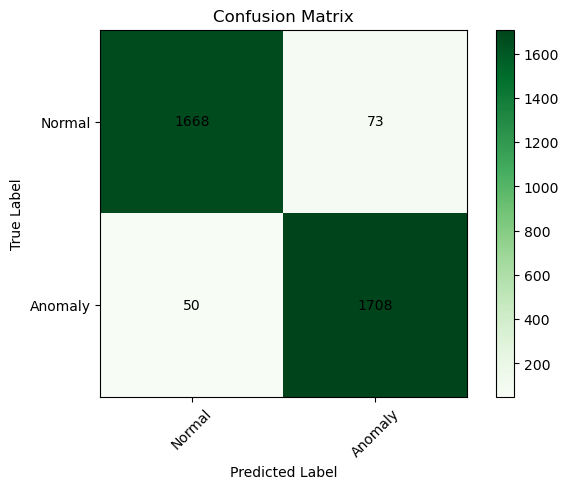

In [15]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

utils.plot_confusion_matrix(results, ['Normal','Anomaly'])

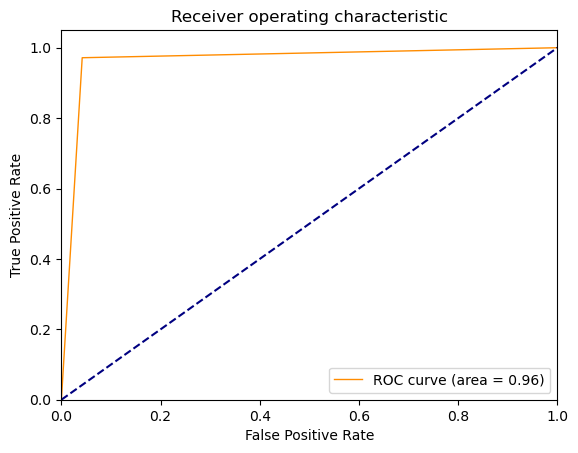

In [16]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

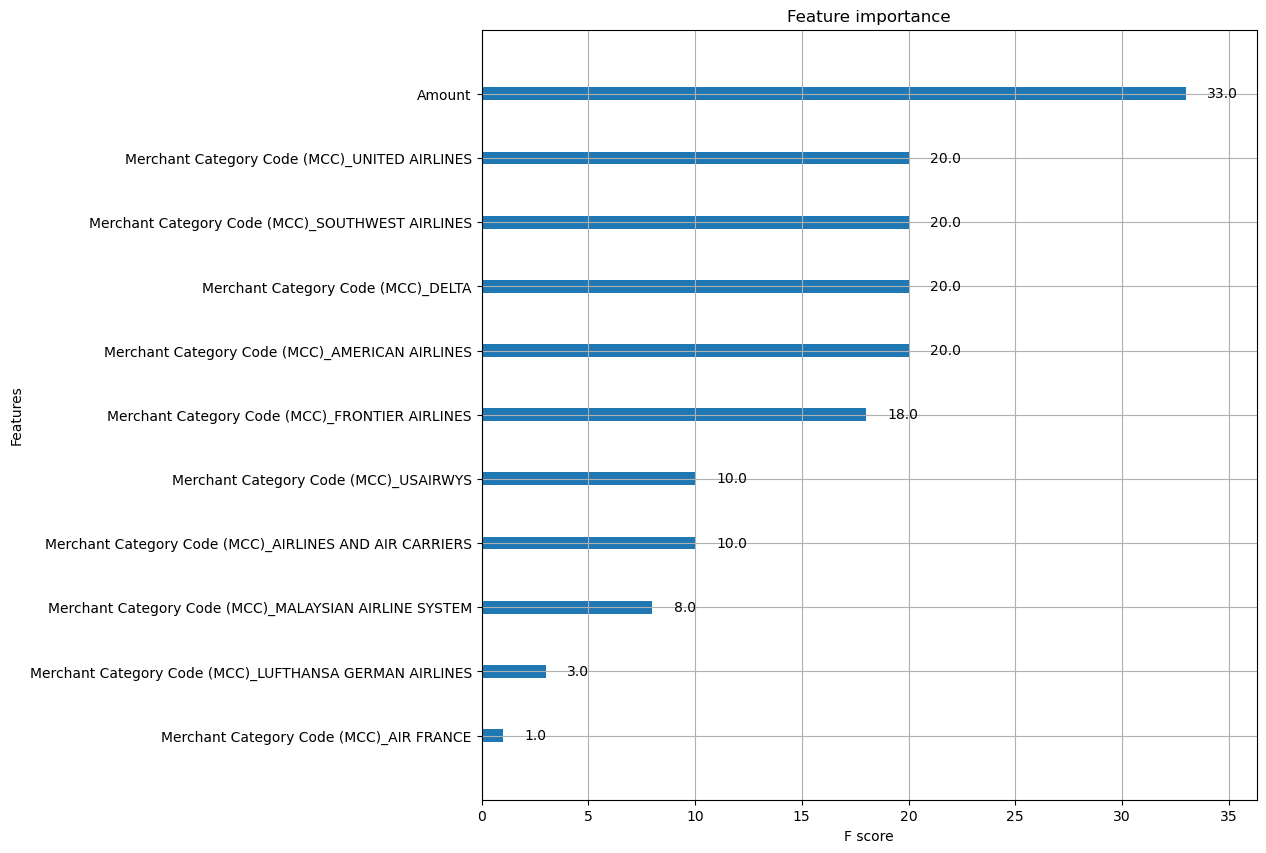

In [17]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

Test for all Dataset

In [23]:
transations_val_2 = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
df_transations_val_2 = transations_val_2[0][0]
labels_val_2 = transations_val_2[1][0]

In [24]:
dtest_val = xgb.DMatrix(df_transations_val_2, label=labels_val_2)

In [25]:
threshold = .5
true_labels_val = labels_val_2.astype(int)

In [26]:
preds_val = model.predict(dtest_val)
pred_labels_val = (preds_val > threshold).astype(int)

In [27]:
auc = roc_auc_score(labels_val_2, pred_labels_val)
print(auc)

0.9619096488333636


In [29]:
print ('Accuracy:', accuracy_score(true_labels_val, pred_labels_val))

Accuracy: 0.9514698867303322


Test for all persons

In [30]:
def calc_accuracy(name: str):
    # Train Model
    x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    evals = [(dtest, 'test'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_rounds, evals=evals)
    #Validation
    transations_val = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
    df_transations_val = transations_val[0][0]
    labels_val = transations_val[1][0]
    dtest_val = xgb.DMatrix(df_transations_val, label=labels_val)
    true_labels_val = labels_val.astype(int)
    preds_val = model.predict(dtest_val)
    pred_labels_val = (preds_val > threshold).astype(int)
    return accuracy_score(true_labels_val, pred_labels_val)

In [33]:
persons = list(df['Cardholder Last Name'].unique())
quantities = df['Cardholder Last Name'].value_counts()
values = []
names = []

for person in persons:
    if quantities[person] > 1000:
        accuracy = calc_accuracy(person)
        values.append(accuracy) 
        names.append(quantities[person])

[0]	test-logloss:0.61163	train-logloss:0.61192
[1]	test-logloss:0.54488	train-logloss:0.54545
[2]	test-logloss:0.48937	train-logloss:0.49021
[3]	test-logloss:0.44270	train-logloss:0.44374
[4]	test-logloss:0.40302	train-logloss:0.40431
[5]	test-logloss:0.36908	train-logloss:0.37059
[6]	test-logloss:0.33981	train-logloss:0.34154
[7]	test-logloss:0.31440	train-logloss:0.31643
[8]	test-logloss:0.29196	train-logloss:0.29425
[9]	test-logloss:0.27257	train-logloss:0.27496
[0]	test-logloss:0.61163	train-logloss:0.61192
[1]	test-logloss:0.54488	train-logloss:0.54545
[2]	test-logloss:0.48937	train-logloss:0.49021
[3]	test-logloss:0.44270	train-logloss:0.44374
[4]	test-logloss:0.40302	train-logloss:0.40431
[5]	test-logloss:0.36908	train-logloss:0.37059
[6]	test-logloss:0.33981	train-logloss:0.34154
[7]	test-logloss:0.31440	train-logloss:0.31643
[8]	test-logloss:0.29196	train-logloss:0.29425
[9]	test-logloss:0.27257	train-logloss:0.27496
[0]	test-logloss:0.61163	train-logloss:0.61192
[1]	test-logl

Text(0, 0.5, 'Accuracy')

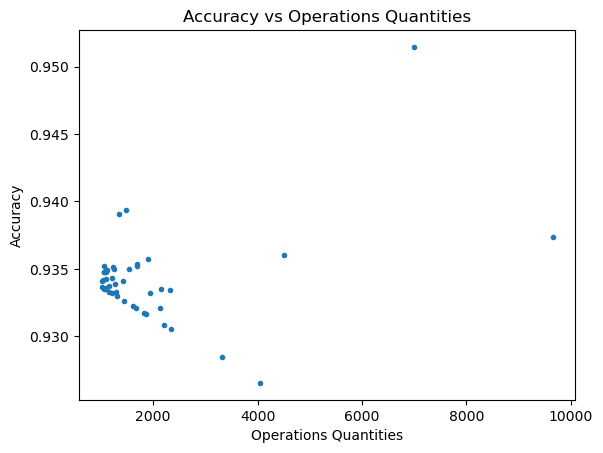

In [34]:
plt.figure()
plt.plot(names, values, ".")
plt.title("Accuracy vs Operations Quantities")
plt.xlabel("Operations Quantities")
plt.ylabel("Accuracy")